# **Modelo #1: Análisis de Correlación para Entender la Relación Entre Precios de Insumos y Exportaciones**

**Objetivo:** Evaluar cómo los costos de insumos agrícolas (por ejemplo, fertilizantes o pesticidas importados) afectan las exportaciones de ciertos cultivos

**Metodología:** Modelos de Random Forest Regressor o Gradient Boosting Regressor, que sirven capturar interacciones y patrones más sofisticados entre los precios de los insumos y las exportaciones. Además la regresión lineal multiple con regularización, también podría darnos un resultado significativo en este caso.

Para empezar con este modelo debemos realizar un Feature Engineering primero de forma que podamos ver si existe una relación entre los precios de índices de insumos agrícolas y el valor de la exportación.

Para la realización del modelo usaremos la librería por excelencia para realizar Machine Learning en Python la cual es [`scikit learn`](https://scikit-learn.org/stable/).

En este caso estaremos llevando a cabo un modelo de predicción que realizará **regresión** para predecir **cuál podría ser el posible precio de las exportaciones de ciertos cultivos teniendo en cuenta diversos factores como los precios a los insumos agrícolas**. Si entonces leemos de nuevo el texto en negrilla, podemos darnos cuenta que en este caso debemos combinar de alguna form ala información que está en los datasets de exportaciones que usamos en el EDA y también el dataset de los índices de los insumos agrícolas que también se encuentra allí. 

¿Por qué realizamos esta predicción? Acá es importante que el enfoque en nuestra propuesta **no es tanto realizar predicciones precisas** sobre el valor futuro de las exportaciones o sobre algún otro target, sino más bien explorar si es posible identificar patrones significativos que revelen relaciones entre las variables (como los precios de los insumos) y las exportaciones de cultivos. Este análisis se apoya en la capacidad de los modelos de machine learning para captar interacciones no lineales y relaciones complejas entre las variables, lo que sería difícil de lograr con un modelo de regresión lineal tradicional. 

Para lograrlo, empleamos distintas técnicas de machine learning, específicamente el **Random Forest Regressor** y **AdaBoost Regressor**, con el fin de capturar relaciones más complejas entre los precios de los insumos agrícolas y el valor de las exportaciones. Además, utilizamos la regresión lineal múltiple con regularización como un modelo base para compararlo con los resultados obtenidos de las técnicas de machine learning y observar que las relaciones entre las variables suelen ser en la mayoría de casos, bastante más complejas que simplemente una relación lineal.

---

Lo primero que haremos es importar lo que necesitamos para nuestro modelo:

In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import Ridge

A continuación, procedemos a importar las bases de datos que serán utilizadas en este análisis. Es importante destacar que la base de datos almacenada en la variable `insumos` es idéntica a la empleada en el análisis exploratorio de datos (EDA), sin realizar ninguna modificación. Sin embargo, la base de datos asignada a la variable `exportaciones` ha sido adaptada a partir de la base original utilizada en el EDA.

Recordemos que la base de datos de exportaciones inicial fue construida con la información de todas las exportaciones del país desde 2018 hasta agosto de 2024. Para focalizarnos en el sector agrícola, se llevó a cabo un proceso de filtrado manual, seleccionando únicamente aquellas categorías de la columna `nombre_capitulo` que correspondían a productos agrícolas. De esta manera, la base de datos exportaciones que utilizamos en esta sección contiene exclusivamente información sobre las exportaciones del sector agrícola. Esta decisión de filtrar la base de datos se tomó con el objetivo de optimizar el tiempo de ejecución de los modelos y evitar redundancias innecesarias en el código.

In [24]:
insumos = pd.read_csv("_ndice_de_precios_de_insumos_agr_colas_20241104.csv")
exportaciones = pd.read_csv("exportaciones_2018_2024_agricultura.csv")

In [25]:
insumos.head()

,Fecha,Indice_total,Total_Fertilizantes,Total_Plaguicidas,Total_Otros,Total_Simples,Total_Compuestos,Total_Herbicidas,Total_Fungicidas,Total_Insecticidas,...,Metomil,Tiametoxam + lambdacihalotrina,Abamectina,Imidacloprid,Profenofos + cipermetrina,Cipermetrina,Profenofos,Total_Coadyuvantes,Total_Reguladores,Total_Molusquicidas
0,12/2018,90.67,90.36,91.24,NaN,91.57,89.41,93.56,90.30,87.04,...,82.84,93.01,90.97,92.52,80.13,85.94,83.91,0.0,0.0,0.0
1,01/2019,92.72,93.49,91.31,NaN,95.64,91.81,93.51,90.47,87.30,...,83.39,92.81,92.02,91.80,80.17,85.39,83.87,0.0,0.0,0.0
2,02/2019,94.06,95.59,91.29,NaN,98.04,93.68,93.34,90.64,87.43,...,82.97,92.90,92.77,92.15,80.44,87.05,83.71,0.0,0.0,0.0
3,03/2019,95.22,97.22,91.58,NaN,99.49,95.45,93.51,91.24,87.72,...,83.33,93.44,92.33,92.21,80.20,87.75,83.82,0.0,0.0,0.0
4,04/2019,95.34,97.27,91.85,NaN,99.19,95.77,93.62,91.63,88.23,...,84.57,93.58,92.27,92.93,81.78,89.43,84.19,0.0,0.0,0.0


Ahora bien, con el fin de ver **cómo los costos de los insumos agrícolas afectan las exportaciones de ciertos cultivos**, debemos hacer uso de la información que nos provee el EDA de la base de datos `Evaluaciones Agropecuarias Municipales – EVA. 2019 - 2023. Base Agrícola` donde se brinda información sobre el área, la producción y el rendimiento de la actividad agropecuaria municipal. Allí se nos muestra la siguiente imagen:

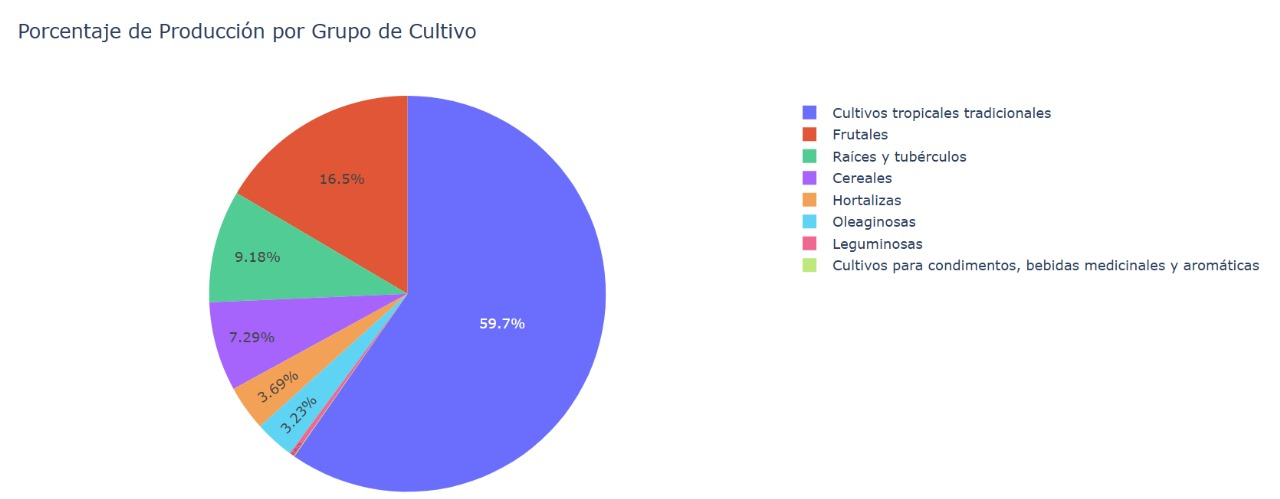

Donde esta nos muestra cuáles son las categorías de la feature `Cultivos` con las cuales contamos en el dataset. Estas categorías son:

* Cultivos tropicales tradicionales
* Frutales
* Raíces y tubérculos
* Cereales
* Hortalizas
* Oleaginosas
* Leguminosas
* Cultivos para condimentos, bebidas medianas y aromáticas

**Entonces el modelo de predicción que haremos solo contará las exportaciones que caigan en esta categoría**. Por eso al principio del dataset se mencionó que el modelo era para algunas de las exportaciones agrícolas y no su totalidad. En estas categorías no se cuenta por ejemplo con una de las más importantes exportaciones, la cual es la que se relaciona con la flora y con derivados del café como pudimos observar en el EDA. Por lo que está limitada a los cultivos seleccionados.

Pero ¿Cómo sabemos qué exportaciones caen en estas categorías? Teniendo en cuenta que ninguna de las categorías coincide con un nombre exacto de alguna de las columnas de la base de datos de exportaciones, lo que hicimos fue crear un diccionario que tuviera palabras que se relacionaban con cada una de las categorías y que se encontraban en la columna categoría `nombre_partida`. Para ver esto más detalladamente, es algo así:

---
```
"Cultivos tropicales tradicionales": ["cultivo", "siembra", "café"]
```

---

Esto significa que dentro de la categoría `Cultivos tropicales tradicionales` caerán todas las exportaciones que tengan en la columna `nombre_partida` las palabras `"cultivo", "siembra", "café"`. Así peus es como funciona la siguiente parte del código:

In [26]:
tipo_cultivo = {
    "Cultivos tropicales tradicionales": ["cultivo", "siembra", "café"],
    "Frutales": ["fruta", "piñas", "aguacates", "bananas"],
    "Raíces y tubérculos": ["raíces", "tubérculos", 'Papa', 'Batata', 'Yuca', 'Ñame', 'Arrurruz', 'Mandioca', 'Camote', 'Oca', 'Taro', 'Raíz de loto',
                            'Apio nabo', 'Almidón de papa', 'Jícama', 'Rábano', 'Salsifí', 'Yam bean', 'Chufa', 'Rutabaga', 'Kale', 'Boniato'],
    "Cereales": ["cereales", "harina"],
    "Hortalizas": ["hortalizas", 'Zanahoria', 'Lechuga', 'Espinaca', 'Tomate', 'Pepino', 'Cebolla', 'Ajo', 'Pimiento', 'Berenjena', 'Brócoli', 'Coliflor',
                   'Apio', 'Guisante', 'Judía verde', 'Calabacín', 'Puerro', 'Rábano', 'Chícharo', 'Remolacha', 'Papas'],
    "Oleaginosas": ["oleaginosas", 'Soya', 'Almendra', 'Cacahuate', 'Nuez', 'Anacardo', 'Acelga', 'Girasol', 'Lino', 'Oliva', 'Sésamo', 'Castaña de cajú',
                    'Pistacho', 'Hemp', 'Nuez de macadamia', 'Chía', 'Acelga', 'Coco', 'Pecan', 'Cártamo'],
    "Leguminosas": ["legumbres", "vegetales", 'Frijol', 'Lenteja', 'Guisante', 'Garbanzos', 'Soja', 'Alfalfa', 'Cacahuate', 'Judía', 'Péverde', 'Chícharo',
                    'Almendra de palo', 'Frijol mungo', 'Frijol negro', 'Frijol pintón', 'Frijol rojo', 'Lupino', 'Habichuela', 'Pescado', 'Tamarindo', 'Frijol de soya'],
    "Cultivos para condimentos, bebidas medianas y aromáticas": ["bebida", "alcohol", "condimentos", "aromática", "especias"]
}


In [27]:
exportaciones['tipo_cultivo'] = exportaciones['nombre_partida'].apply(
    lambda nombre_partida: next(
        (cultivo for cultivo, keywords in tipo_cultivo.items() 
         if any(keyword in str(nombre_partida).lower() for keyword in keywords)),
        "No asignado"
    )
)

exportaciones.drop(columns=["Unnamed: 0", "unnamed:_0", "departamento_origen", "pais_destino", "codigo_capitulo"])
exportaciones.head()

,Unnamed: 0,unnamed:_0,anio,mes,codigo_depto_origen,departamento_origen,codigo_pais_destino,pais_destino,codigo_partida,nombre_partida,...,descripcion_ciiu_rev4,codigo_capitulo,nombre_capitulo,nivel_tecnologico,codigo_unidad,unidad,dolares_fob,kilogramos_netos,cantidad,tipo_cultivo
0,0,9,2018,1,5,antioquia,17,albania,803,"bananas_o_plátanos,_frescos_o_secos",...,cultivo_de_plátano_y_banano,8,"frutos_comestibles,_cortezas_de_agrios_o_melones",bienes_primarios,kg,kilogramo,72576.00,168480.0,168480.0,Frutales
1,1,15,2018,1,5,antioquia,23,alemania,511,productos_de_origen_animal_no_expresados_ni_co...,...,procesamiento_y_conservación_de_carne_y_produc...,5,demás_productos_de_origen_animal,bienes_primarios,kg,kilogramo,14850.00,33000.0,33000.0,No asignado
2,2,16,2018,1,5,antioquia,23,alemania,603,"flores_y_capullos,_cortados_para_ramos_o_adorn...",...,cultivo_de_flor_de_corte,6,plantas_vivas_y_productos_de_la_floricultura,bienes_primarios,u,unidades_o_artículos,1625.10,334.0,3060.0,No asignado
3,3,17,2018,1,5,antioquia,23,alemania,803,"bananas_o_plátanos,_frescos_o_secos",...,cultivo_de_plátano_y_banano,8,"frutos_comestibles,_cortezas_de_agrios_o_melones",bienes_primarios,kg,kilogramo,4730443.55,13466579.0,13466579.0,Frutales
4,4,18,2018,1,5,antioquia,23,alemania,804,"dátiles,_higos,_piñas_(ananás),__aguacates_(pa...",...,cultivo_de_frutas_tropicales_y_subtropicales,8,"frutos_comestibles,_cortezas_de_agrios_o_melones",bienes_primarios,kg,kilogramo,210805.38,109190.0,109190.0,Frutales


In [28]:
exportaciones.tipo_cultivo.value_counts()

tipo_cultivo
No asignado                                                 148219
Cultivos tropicales tradicionales                            29760
Frutales                                                     23439
Cereales                                                     22360
Cultivos para condimentos, bebidas medianas y aromáticas     17521
Hortalizas                                                    5603
Leguminosas                                                   4987
Raíces y tubérculos                                           3825
Name: count, dtype: int64

Acá vemos que la mayoría de exportaciones quedó sin asignación lo cual tiene sentido recordando que estamos dejando fuera las exportaciones de mayor volumen (flora, carne, animales, café y derivados, etc)

---

Ahora, para poder unir la información de los índices de los insumos con las exportaciones, lo que haremos será usar el `año` y el `indice_total`. Esto es, que agregaremos la columna `indice_total` a la base de datos de `exportaciones` utilizando el año como factor común entre ambas bases. La información de `indice_total` se encuentra con un formato de MES/AÑO, lo que haremos entonces **será sacar el promedio del `indice_total` por año y agregarlo a la data de `exportaciones`**  de modo que cuando diga 2018, el índice será el promedio de los `indice_totales` del año 2018, y así sucesivamente hasta 2024. Esto se ve d ela siguiente forma:

In [29]:
insumos['anio'] = pd.to_datetime(insumos['Fecha'], format='%m/%Y').dt.year
insumos_promedio = insumos.groupby('anio')['Indice_total'].mean().reset_index()
exportaciones = exportaciones.merge(insumos_promedio, on='anio', how='left')
exportaciones.drop(columns=["Unnamed: 0", "unnamed: 0"], errors='ignore', inplace=True)
exportaciones.head()


,unnamed:_0,anio,mes,codigo_depto_origen,departamento_origen,codigo_pais_destino,pais_destino,codigo_partida,nombre_partida,codigo_ciiu_rev4,...,codigo_capitulo,nombre_capitulo,nivel_tecnologico,codigo_unidad,unidad,dolares_fob,kilogramos_netos,cantidad,tipo_cultivo,Indice_total
0,9,2018,1,5,antioquia,17,albania,803,"bananas_o_plátanos,_frescos_o_secos",NaN,...,8,"frutos_comestibles,_cortezas_de_agrios_o_melones",bienes_primarios,kg,kilogramo,72576.00,168480.0,168480.0,Frutales,90.67
1,15,2018,1,5,antioquia,23,alemania,511,productos_de_origen_animal_no_expresados_ni_co...,NaN,...,5,demás_productos_de_origen_animal,bienes_primarios,kg,kilogramo,14850.00,33000.0,33000.0,No asignado,90.67
2,16,2018,1,5,antioquia,23,alemania,603,"flores_y_capullos,_cortados_para_ramos_o_adorn...",NaN,...,6,plantas_vivas_y_productos_de_la_floricultura,bienes_primarios,u,unidades_o_artículos,1625.10,334.0,3060.0,No asignado,90.67
3,17,2018,1,5,antioquia,23,alemania,803,"bananas_o_plátanos,_frescos_o_secos",NaN,...,8,"frutos_comestibles,_cortezas_de_agrios_o_melones",bienes_primarios,kg,kilogramo,4730443.55,13466579.0,13466579.0,Frutales,90.67
4,18,2018,1,5,antioquia,23,alemania,804,"dátiles,_higos,_piñas_(ananás),__aguacates_(pa...",NaN,...,8,"frutos_comestibles,_cortezas_de_agrios_o_melones",bienes_primarios,kg,kilogramo,210805.38,109190.0,109190.0,Frutales,90.67


Así pues, tenemos que los indices toales para cada año son:

In [30]:
exportaciones.groupby(["anio", "Indice_total"]).size().reset_index(name="frecuencia")

,anio,Indice_total,frecuencia
0,2018,90.670000,34492
1,2019,95.619167,36317
2,2020,99.295000,36202
3,2021,123.621667,39349
4,2022,209.119167,39479
5,2023,180.758333,41425
6,2024,138.417778,28450


A fin de incorporar la información sobre los países de destino en el modelo, procederemos a agruparlos en intervalos de frecuencia. Estos intervalos se establecerán en rangos de 2000 unidades, iniciando desde 1 hasta 25000. De esta manera, cada país de destino será asignado a un intervalo específico según el valor numérico asociado a él. Esto es:

In [31]:
def asignar_grupos_por_frecuencia(df):
    pais_frecuencia = df['pais_destino'].value_counts()
    bins = [1, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 25000]
    labels = range(1, len(bins))

    pais_group = {}
    for pais, count in pais_frecuencia.items():
        for i in range(len(bins) - 1):
            if bins[i] <= count < bins[i + 1]:
                pais_group[pais] = i + 1  # Asignar el grupo (1, 2, ..., 12)
                break

    df['pais_destino_group'] = df['pais_destino'].map(pais_group)

    return df

# Aplicar la asignación de grupos al conjunto completo
exportaciones = asignar_grupos_por_frecuencia(exportaciones)

<AxesSubplot:xlabel='pais_destino_group', ylabel='Count'>

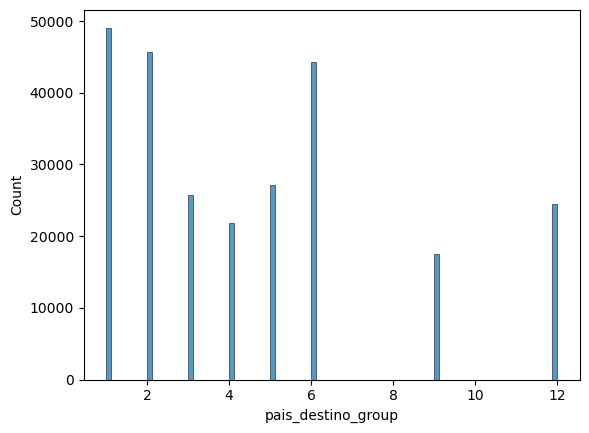

In [32]:
sns.histplot(exportaciones.pais_destino_group)

## **Empezamos el modelo**

Primero dividimos nuestra data en la data de entrenamiiento, validación y testeo, lo que es `df_train`, `df_val`, `df_test` respectivamente:

In [33]:
df_full_train, df_test = train_test_split(exportaciones, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.dolares_fob.values)
y_val = np.log1p(df_val.dolares_fob.values)
y_test = np.log1p(df_test.dolares_fob.values)

del df_train['dolares_fob']
del df_val['dolares_fob']
del df_test['dolares_fob']

df_full_train = df_full_train.reset_index(drop=True)

In [34]:
len(df_train), len(df_val), len(df_test)

(153428, 51143, 51143)

Utilizamos un `LabelEncoder` que asignará un numero a cada categoría de la feature `tipo_cultivo` que agregamos anteriormente. Lo aplicamos para los 3 datasets:

In [35]:
label_encoder = LabelEncoder()
df_train['tipo_cultivo_encoded'] = label_encoder.fit_transform(df_train['tipo_cultivo'])
df_val['tipo_cultivo_encoded'] = label_encoder.fit_transform(df_val['tipo_cultivo'])
df_test['tipo_cultivo_encoded'] = label_encoder.fit_transform(df_test['tipo_cultivo'])

Hacemos `OneHotEncoding` para la columna `tipo_cultivo_encoded` que creamos justo en la celda anterior y la de `pais_destino_group` para que nos quede todo en términos de $0$ y $1$ y no existan sesgos y/o errores cuando se estén realizando las multiplicaciones de matrices con las que funcionan los modelos de regresión:

In [36]:
def aplicar_one_hot_encoding(df, columns_to_encode):
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(df[columns_to_encode])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))
    
    df_encoded = df.drop(columns=columns_to_encode).join(encoded_df)
    
    return df_encoded

columns_to_encode = ['pais_destino_group', "tipo_cultivo_encoded"]
df_train = aplicar_one_hot_encoding(df_train, columns_to_encode)
df_val = aplicar_one_hot_encoding(df_val, columns_to_encode)
df_test = aplicar_one_hot_encoding(df_test, columns_to_encode)

Seleccionamos las columnas que usaremos para el modelo:

In [37]:
columns_selected = ["Indice_total", "cantidad", "kilogramos_netos", 'pais_destino_group_1',
       'pais_destino_group_2', 'pais_destino_group_3', 'pais_destino_group_4',
       'pais_destino_group_5', 'pais_destino_group_6', 'pais_destino_group_9',
       'pais_destino_group_12', 'tipo_cultivo_encoded_0',
       'tipo_cultivo_encoded_1', 'tipo_cultivo_encoded_2',
       'tipo_cultivo_encoded_3', 'tipo_cultivo_encoded_4',
       'tipo_cultivo_encoded_5', 'tipo_cultivo_encoded_6',
       'tipo_cultivo_encoded_7',"anio"]

Observamos la correlación entre ellas para que no caigamos en overfitting:

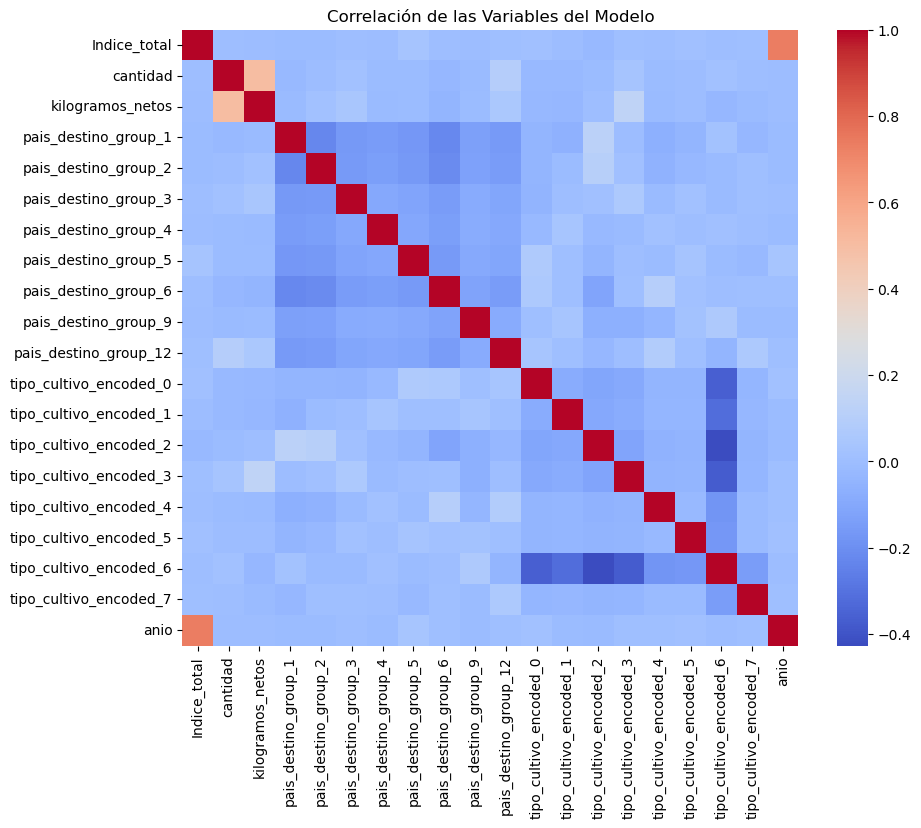

In [38]:
df_selected = df_train[columns_selected]
corr_matrix = df_selected.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True)
plt.title('Correlación de las Variables del Modelo')
plt.show()

In [39]:
X_train = df_train[columns_selected]
X_val = df_val[columns_selected]
X_test = df_test[columns_selected]

Aplicamos los modelos. Como mencionamos usaremos **Regresión Lineal, Random Forest, AdaBoost**. Imprimimos los score y las métricas que normalmente se usan para los porblemas de regresión, las cuales son MAPE, MSE y RMSE. El "score" es en realidad el coeficiente de determinación $R^2$ el cual nos indica qué proporción de la variabilidad de una variable dependiente puede ser explicada por una o más variables independientes en un modelo de regresión como el nuestro. Este escore es entonces muy importante para nosotras ya que es lo que buscamos: queremos ver qué tanta relación hay entre los indices de precios de insumos agrícolas y los diferentes tipos de cultivos que se exportan. Mirando los resultados de nuestros modelos:

### **Regresión Lineal con Regularización de Ridge:**

In [40]:
# =========================== Regresión lineal con regularización Ridge ====================================
print("**********Scores y resultados para Regularización de Ridge**********")
ridge = Ridge(alpha=10).fit(X_train, y_train)  # mejor alpha escogido con hyperparameter tuning con CV

# Calcular el R² en los conjuntos de entrenamiento, prueba y validación
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))
print("Validation set score: {:.2f}".format(ridge.score(X_val, y_val)))

# Realizar predicciones sobre el conjunto de prueba
y_pred_ridge = ridge.predict(X_test)

# Calcular MSE, RMSE y MAPE para el modelo Ridge en el conjunto de prueba
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
mape_ridge = mean_absolute_percentage_error(y_test, y_pred_ridge)

print(f"\nMSE para Ridge en el conjunto de prueba: {mse_ridge:.4f}")
print(f"RMSE para Ridge en el conjunto de prueba: {rmse_ridge:.4f}")
print(f"MAPE para Ridge en el conjunto de prueba: {mape_ridge:.4f}")

**********Scores y resultados para Regularización de Ridge**********
Training set score: 0.20
Test set score: 0.21
Validation set score: 0.20

MSE para Ridge en el conjunto de prueba: 5.9454
RMSE para Ridge en el conjunto de prueba: 2.4383
MAPE para Ridge en el conjunto de prueba: 0.6659


/home/eli_gran/anaconda3/envs/gitdocs/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.56835e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


### **Random Forest**

In [41]:
# =========================== Random Forest ====================================
print("**********Scores y resultados para Random Forest**********")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print("Training set score: {:.2f}".format(rf.score(X_train, y_train)))
print("Test set score: {:.2f}".format(rf.score(X_test, y_test)))
print("Validation set score: {:.2f}".format(rf.score(X_val, y_val)))

y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
r2_rf = rf.score(X_test, y_test)

print(f"\nMSE para Random Forest en el conjunto de prueba: {mse_rf:.4f}")
print(f"RMSE para Random Forest en el conjunto de prueba: {rmse_rf:.4f}")
print(f"MAPE para Random Forest en el conjunto de prueba: {mape_rf:.4f}")
print(f"R² para Random Forest en el conjunto de prueba: {r2_rf:.4f}")

**********Scores y resultados para Random Forest**********
Training set score: 0.97
Test set score: 0.86
Validation set score: 0.86

MSE para Random Forest en el conjunto de prueba: 1.0562
RMSE para Random Forest en el conjunto de prueba: 1.0277
MAPE para Random Forest en el conjunto de prueba: 0.2360
R² para Random Forest en el conjunto de prueba: 0.8588


### **AdaBoost:**

In [42]:
# ===================================AdaBoost ===================================
print("\n**********Scores y resultados para AdaBoost**********")
ab = AdaBoostRegressor(n_estimators=100, random_state=42, learning_rate=0.05)
ab.fit(X_train, y_train)

print("Training set score: {:.2f}".format(ab.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ab.score(X_test, y_test)))
print("Validation set score: {:.2f}".format(ab.score(X_val, y_val)))

# Predicción sobre el conjunto de prueba
y_pred_ab = ab.predict(X_test)

# Evaluación con MSE, RMSE, MAPE y R² para AdaBoost
mse_ab = mean_squared_error(y_test, y_pred_ab)
rmse_ab = np.sqrt(mse_ab)
mape_ab = mean_absolute_percentage_error(y_test, y_pred_ab)
r2_ab = ab.score(X_test, y_test)

print(f"\nMSE para AdaBoost en el conjunto de prueba: {mse_ab:.4f}")
print(f"RMSE para AdaBoost en el conjunto de prueba: {rmse_ab:.4f}")
print(f"MAPE para AdaBoost en el conjunto de prueba: {mape_ab:.4f}")
print(f"R² para AdaBoost en el conjunto de prueba: {r2_ab:.4f}")



**********Scores y resultados para AdaBoost**********
Training set score: 0.80
Test set score: 0.80
Validation set score: 0.80

MSE para AdaBoost en el conjunto de prueba: 1.4918
RMSE para AdaBoost en el conjunto de prueba: 1.2214
MAPE para AdaBoost en el conjunto de prueba: 0.3521
R² para AdaBoost en el conjunto de prueba: 0.8006


In [43]:
# Revertir la transformación de logaritmo para el MAPE en la escala original
y_test_original = np.expm1(y_test)
y_pred_rf_original = np.expm1(y_pred_rf)

mape_rf_original = mean_absolute_percentage_error(y_test_original, y_pred_rf_original)
print(f"MAPE para Random Forest en la escala original: {mape_rf_original:.4f}%")

MAPE para Random Forest en la escala original: 38.2544%


Las conclusiones sobre este modelo se encuentran en el archivo `Conclusiones_Modelos.md`

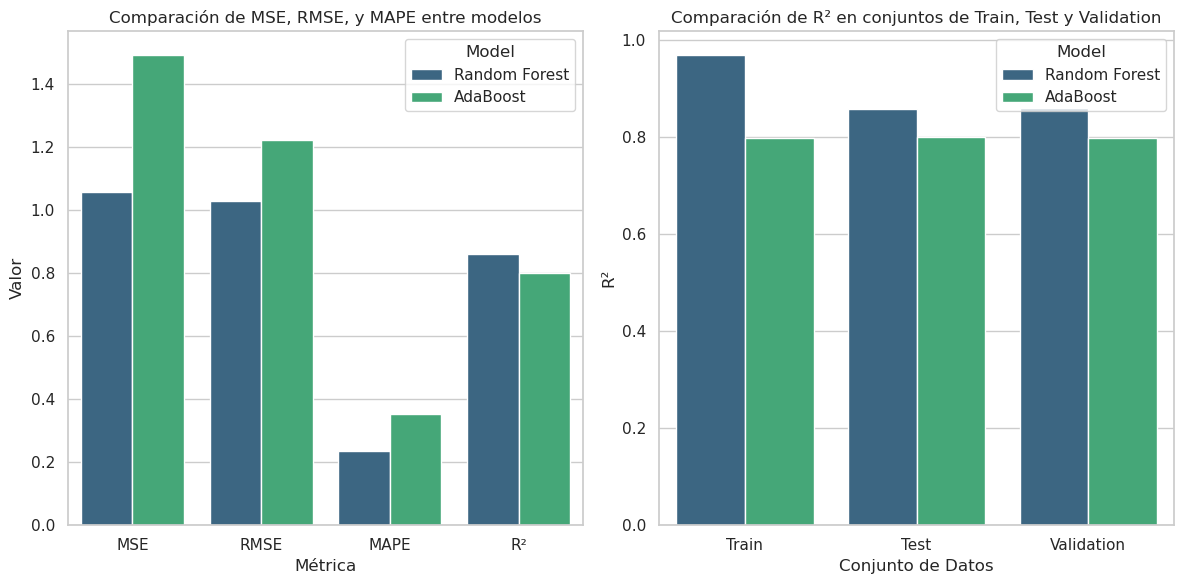

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Datos de métricas y scores de cada modelo
metrics = {
    'Metric': ['MSE', 'RMSE', 'MAPE', 'R²'],
    'Random Forest': [mse_rf, rmse_rf, mape_rf, r2_rf],
    'AdaBoost': [mse_ab, rmse_ab, mape_ab, r2_ab]
}

# Crear DataFrame para métricas
import pandas as pd
metrics_df = pd.DataFrame(metrics)

# Configurar el estilo de las gráficas
sns.set(style="whitegrid")

# Gráfica de métricas (MSE, RMSE, MAPE)
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
sns.barplot(data=metrics_df.melt(id_vars="Metric", var_name="Model", value_name="Score"),
            x="Metric", y="Score", hue="Model", palette="viridis", ax=ax1)
ax1.set_title("Comparación de MSE, RMSE, y MAPE entre modelos")
ax1.set_ylabel("Valor")
ax1.set_xlabel("Métrica")

# Gráfica de R² en entrenamiento, prueba y validación
# Agregar puntajes de entrenamiento y validación para cada modelo
r2_scores = {
    'Dataset': ['Train', 'Test', 'Validation'],
    'Random Forest': [rf.score(X_train, y_train), rf.score(X_test, y_test), rf.score(X_val, y_val)],
    'AdaBoost': [ab.score(X_train, y_train), ab.score(X_test, y_test), ab.score(X_val, y_val)]
}

r2_scores_df = pd.DataFrame(r2_scores)

# Plot R² Scores
ax2 = plt.subplot(1, 2, 2)
sns.barplot(data=r2_scores_df.melt(id_vars="Dataset", var_name="Model", value_name="R² Score"),
            x="Dataset", y="R² Score", hue="Model", palette="viridis", ax=ax2)
ax2.set_title("Comparación de R² en conjuntos de Train, Test y Validation")
ax2.set_ylabel("R²")
ax2.set_xlabel("Conjunto de Datos")

plt.tight_layout()
plt.show()
